In [ ]:
%pip install deap

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

df = pd.read_csv('./data/processed_mrna_zscore.csv')

In [2]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

Select 500 features by filtering methods.

In [3]:
file_path = './top_features_rf_500.txt'

with open(file_path, 'r') as file:
    content = file.read().splitlines()
top500 = content

The search space is now in 500 top features selected by a filtering methods

In [4]:
target_n = 50

In [5]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import StratifiedKFold
# Assuming X and y are your feature matrix and target variable
# X is a pandas DataFrame with 1800 samples and 500 features
# y is a pandas Series with the corresponding labels

# DEAP initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual (binary representation of features)
def create_individual():
    return np.random.choice(top500, size=target_n, replace=False)

def mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            remain = [feat for feat in top500 if feat not in individual]
            individual[i] = np.random.choice(remain)
    return individual,
# DEAP Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

Genetic algorithm settings

In [6]:
population_size = 50
generations = 20
crossover_rate = 0.8
mutation_rate = 0.1

In [7]:
def execuate_ga(clf):
    # Collect fitness values for plotting
    mean_fitness_values = []

    population = toolbox.population(n=population_size)

    for gen in range(generations):
        # Evaluate the entire population
        fitness_values = list(toolbox.map(toolbox.evaluate, population))
        
        # Update the fitness values
        for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation individuals
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        
        # Evaluate offspring
        fitness_values = list(toolbox.map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation from offspring
        population = toolbox.select(offspring + population, k=population_size)
        
        # Collect the highest fitness value for this generation
        mean_fitness = np.array([ind.fitness.values[0] for ind in population]).mean()
        mean_fitness_values.append(mean_fitness)

        # Print the highest fitness value for this generation
        print(f"Generation {gen + 1}: Mean Fitness = {mean_fitness}")

    
    # Plotting
    plt.plot(range(1, generations + 1), mean_fitness_values, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Mean Fitness Value')
    plt.title('Evolution of Highest Fitness Value')
    plt.show()

    # Get the best individual from the final population
    best_individual = tools.selBest(population, k=1)[0]


    np.savetxt(f'top_features_gen_{clf}.txt', best_individual, fmt='%s')

    print("Best individual:", best_individual)

    return mean_fitness_values

XGB Boost

In [8]:
label_mapping = {'short': 0, 'medium': 1, 'long': 2}
y_numerical = y.map(label_mapping)

# # Now, 'y_numerical' contains the encoded numerical values
print(y_numerical)
y = y_numerical

0       2
1       1
2       2
3       2
4       2
       ..
1975    2
1976    2
1977    2
1978    2
1979    2
Name: OS_RANGE, Length: 1980, dtype: int64


In [11]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
# Function to evaluate the fitness of an individual
def evaluate_individual_xgb(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    selected_features = list(set(selected_features))
    clf = xgb.XGBClassifier(random_state=42, n_estimators=10, n_jobs=-1)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

Generation 1: Mean Fitness = 0.7402828282828282
Generation 2: Mean Fitness = 0.7436161616161617
Generation 3: Mean Fitness = 0.7470606060606062
Generation 4: Mean Fitness = 0.7498686868686869
Generation 5: Mean Fitness = 0.7522626262626262
Generation 6: Mean Fitness = 0.754111111111111
Generation 7: Mean Fitness = 0.7554747474747472
Generation 8: Mean Fitness = 0.7574646464646463
Generation 9: Mean Fitness = 0.7586464646464646
Generation 10: Mean Fitness = 0.759121212121212
Generation 11: Mean Fitness = 0.7591717171717169
Generation 12: Mean Fitness = 0.7592929292929295
Generation 13: Mean Fitness = 0.7594848484848484
Generation 14: Mean Fitness = 0.7595858585858585
Generation 15: Mean Fitness = 0.7596565656565656
Generation 16: Mean Fitness = 0.7597777777777779
Generation 17: Mean Fitness = 0.7598989898989899
Generation 18: Mean Fitness = 0.7602626262626262
Generation 19: Mean Fitness = 0.7611313131313131
Generation 20: Mean Fitness = 0.7624848484848485


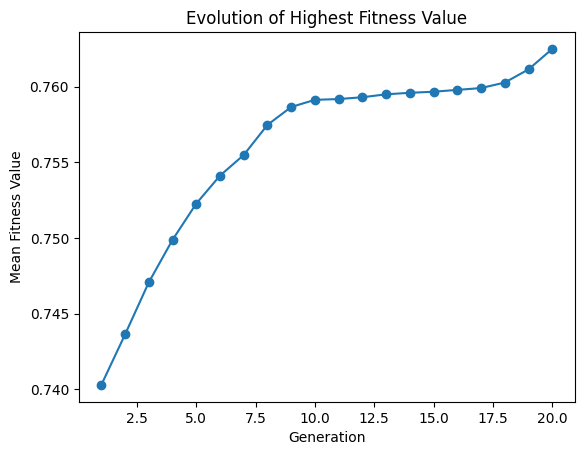

Best individual: ['KLHDC2', 'ASZ1', 'CEACAM6', 'GATA6', 'FAM177B', 'SLC35C1', 'LOC645177', 'C10orf129', 'PCBD2', 'OR6B2', 'DUSP21', 'C17orf50', 'LINC01838', 'AVP', 'LPHN1', 'HOXA4', 'SELENOT', 'GRHPR', 'IDH3GL', 'KRTAP4-11', 'GPX2', 'MOBP', 'ZNF646', 'CBARP', 'SLC25A5', 'TMA16', 'KCNG1', 'LAGE3', 'COQ7', 'TMEM189', 'CDC14C', 'PREX1', 'RNASE2', 'PLK1', 'AQP6', 'MYO3A', 'CA12', 'PADI1', 'C3orf36', 'HIF1AN', 'TBC1D1', 'CC2D2B', 'MYO3A', 'S100A3', 'FBL', 'SNRPA1', 'MID1', 'SRSF10', 'OXGR1', 'CHST4']


[0.7402828282828282,
 0.7436161616161617,
 0.7470606060606062,
 0.7498686868686869,
 0.7522626262626262,
 0.754111111111111,
 0.7554747474747472,
 0.7574646464646463,
 0.7586464646464646,
 0.759121212121212,
 0.7591717171717169,
 0.7592929292929295,
 0.7594848484848484,
 0.7595858585858585,
 0.7596565656565656,
 0.7597777777777779,
 0.7598989898989899,
 0.7602626262626262,
 0.7611313131313131,
 0.7624848484848485]

In [12]:
toolbox.register("evaluate", evaluate_individual_xgb)
execuate_ga('xgb')

In [ ]:
mean_fitness_values = [0.7402828282828282,
 0.7436161616161617,
 0.7470606060606062,
 0.7498686868686869,
 0.7522626262626262,
 0.754111111111111,
 0.7554747474747472,
 0.7574646464646463,
 0.7586464646464646,
 0.759121212121212,
 0.7591717171717169,
 0.7592929292929295,
 0.7594848484848484,
 0.7595858585858585,
 0.7596565656565656,
 0.7597777777777779,
 0.7598989898989899,
 0.7602626262626262,
 0.7611313131313131,
 0.7624848484848485]

plt.plot(range(1, generations + 1), mean_fitness_values, marker='o', color='orange')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness Value')
plt.title('Mean Fitness Value - GA and XGBoost')
plt.show()